# Práctica 2 - Clasificación

En esta práctica se presenta el modelo de clasificación más optimizado al que se ha llegado para el caso de predicción del equipo ganador de una ronda de Counter Strike: Global Offensive y como se ha llegado al mismo.

Video explicativo: https://drive.google.com/file/d/1GlFTv8TfftQab4SxkMXNmrFlk-Vx-VNX/view?usp=sharing

## 1 - Inicialización

### Imports

Empezamos importando todas las librerías que se van a utilizar a lo largo de esta libreta.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import math
from sklearn import preprocessing
import sklearn.compose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,cross_val_score, cross_validate, KFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
import re

### Carga de datos

Importamos los datos y separamos en los datos de entrenamiento la columna de la variable objetivo de las demas variables. También creamos dos copias adicionales de los datos de entrenamiento que se utilizarán para realizar estudios y como referencia para algunas funciones.


In [3]:
#Datos de entrenamiento
datosTrain = pd.read_csv("train.csv")

#Datos de estudio y referencia
datosReferencia = pd.read_csv("train.csv")
datosEstudio = pd.read_csv("train.csv")  

#Separación de la columna de datos objetivo de los datos de entrenamiento
datosWinner = datosTrain["round_winner"]
datosTrain = datosTrain.drop(['round_winner', 'round_winner.1'], axis = 1)

#Datos a predecir
datosTest = pd.read_csv("test.csv")
datosTestId = pd.DataFrame({"id":datosTest["id"]})
datosTest = datosTest.drop(['id'], axis = 1)

## 2 - Estudio

In [4]:
datosTrain

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,175.00,10.0,12.0,de_vertigo,False,500.0,500.0,500.0,85.0,6550.0,...,5.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,108.16,7.0,8.0,de_train,False,500.0,500.0,300.0,300.0,450.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.15,0.0,1.0,de_train,True,75.0,295.0,93.0,298.0,350.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,174.87,14.0,2.0,de_nuke,False,500.0,500.0,190.0,0.0,19900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.95,8.0,12.0,de_mirage,False,500.0,500.0,0.0,483.0,26350.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,114.93,5.0,12.0,de_inferno,False,500.0,500.0,288.0,441.0,11800.0,...,1.0,4.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0
73442,174.93,3.0,2.0,de_train,False,500.0,500.0,177.0,398.0,24000.0,...,1.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0
73443,114.93,13.0,8.0,de_nuke,False,500.0,500.0,422.0,500.0,16900.0,...,5.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0
73444,114.90,12.0,14.0,de_mirage,False,500.0,500.0,500.0,500.0,23600.0,...,5.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0


Para el estudio de los datos vamos a realizar un analisis de la correlación de las distintas variables con la variable objetivo `round_winner`.

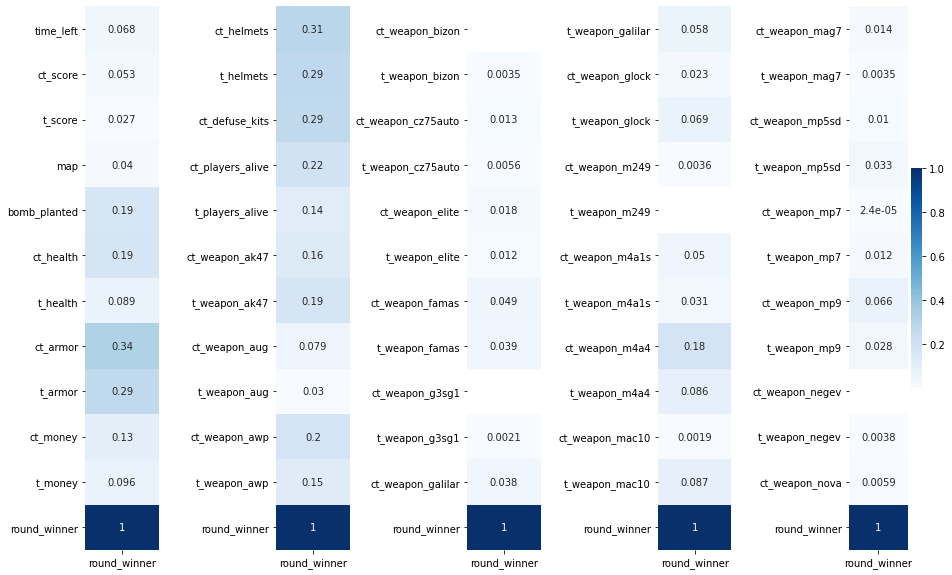

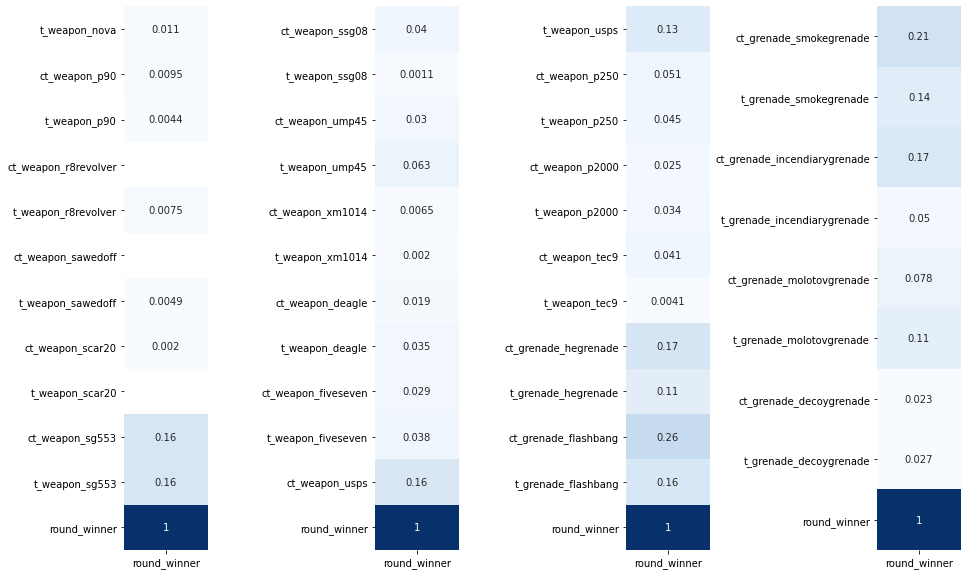

In [20]:
# Sustituimos los valores categóricos por enteros en función de la categoría
enc = preprocessing.OrdinalEncoder()
datosEstudio[["map", "bomb_planted","round_winner"]] = enc.fit_transform(datosEstudio[["map", "bomb_planted","round_winner"]])

fig, ax = plt.subplots(1, 5, figsize=(15,10))
plt.subplots_adjust(wspace=1.6)
fig2, ax2 = plt.subplots(1, 4, figsize=(15,10))
plt.subplots_adjust(wspace=2)


#Usamos la correlación de Pearson para imprimir unas matrices de correlaciones
datosCorr1 = datosEstudio.iloc[:, np.r_[:11,96]]
cor = datosCorr1.corr()
h1 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax[0])

datosCorr2 = datosEstudio.iloc[:, np.r_[11:22,96]]
cor = datosCorr2.corr()
h2 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax[1])

datosCorr3 = datosEstudio.iloc[:, np.r_[22:33,96]]
cor = datosCorr3.corr()
h3 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax[2])

datosCorr4 = datosEstudio.iloc[:, np.r_[33:44,96]]
cor = datosCorr4.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax[3])

datosCorr5 = datosEstudio.iloc[:, np.r_[44:55,96]]
cor = datosCorr5.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, ax=ax[4])

datosCorr6 = datosEstudio.iloc[:, np.r_[55:66,96]]
cor = datosCorr6.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax2[0])

datosCorr7 = datosEstudio.iloc[:, np.r_[66:77,96]]
cor = datosCorr7.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax2[1])

datosCorr8 = datosEstudio.iloc[:, np.r_[77:88,96]]
cor = datosCorr8.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax2[2])

datosCorr9 = datosEstudio.iloc[:, np.r_[88:len(datosEstudio.columns)]]
cor = datosCorr9.corr()
h4 = sns.heatmap(abs(cor.loc[:,['round_winner']]), annot=True, cmap=plt.cm.Blues, cbar=False, ax=ax2[3])

De esta tabla de correlaciones podemos sacar distintas conclusiones que nos ayudarán a la hora de elegir que tipos de preprocesamientos probar. 

Lo primero que salta a la vista es que hay varias correlaciones que no tiene dato, esto es debido a que no tienen ningun tipo de correlación con la variable objetivo muy seguramente debido a que siempre tengan el mismo valor (en este caso 0). 

Tambien se observa otro gran número de armas con muy poca correlación con la variable objetivo por lo que tambien se puede probar a eliminarlas o combinarlas de alguna manera que junte su valor. 

Por último, vemos que las variables que no son armas (las primeras 16) por lo general aportan una cantidad de información relevante a excepción de `time_left`, `t_score`, `ct_score` y `map`. En el caso de `time_left` puede ser debido a que es mucho más relevante fijarse en el estado de la ronda en el momento que en cuanto tiempo queda, por ejemplo, por mucho tiempo que quede, será muy dificil remontar si el equipo contrario tiene mejor equipamiento. En el caso de `t_score`, `ct_score`, podríamos deducir que no parece muy relevante conocer quien ha ganado mayor número de rondas anteriormente a la hora de decidir la ronda actual, lo cual puede ser debido a que los datos son de partidas competitivas de alto nivel donde todo el mundo estará muy igualado. Para acabar, `map` tampoco parece tener mucha relevancia, podemos suponer que los mapas estan bien balanceados sin dar ventaja a ninguno de los equipos.

## 3 - Preprocesado

### 3.1 - Codificación

Como primer paso se ha optado por codificar las variables categóricas con un ordinal encoder para que puedan ser entendidos por los clasificadores.

In [ ]:
enc = preprocessing.OrdinalEncoder()
datosReferencia[["map", "bomb_planted","round_winner"]] = enc.fit_transform(datosReferencia[["map", "bomb_planted","round_winner"]])
datosTrain[["map", "bomb_planted"]] = enc.fit_transform(datosTrain[["map", "bomb_planted"]])
datosTest[["map", "bomb_planted"]] = enc.fit_transform(datosTest[["map", "bomb_planted"]])

### 3.2 - Pruebas

Basandonos en lo obtenido en el análisis de correlaciones se ha optado por probar diversas transformaciones:
* **Armas menores**: se ha probado a sumar los valores de todas las columnas de armas con valor menor o igual que 0,05 en su correlación con `round_winner` en dos columnas, una para terroristas y otra para contraterroristas. El resultado fue satisfactorio ya que se consiguió aumentar el valor del f1 en un par de centésimas además de reducir a la mitad el número de columnas del dataset, lo cual disminuye considerablemente la complejidad de los modelos y el tiempo de procesado.
* **Armas mayores**: debido al éxito de la prueba de armas menores, se probó tambien a hacer lo mismo con las armas cuya correlación con `round_winner` fuera mayor que 0,05. En este caso sin embargo, supuso una bajada considerable de la valoración del modelo muy probablemente debida a que algunas armas si aportan una gran cantidad de información por si solas (por ser las que mejor funcionan en las rondas) y pese a suponer otra gran reducción del número de columnas, combinarlas supone una pérdida de información considerable.
* **Diferencias de dinero, salud, armadura**: se intentó añadir una nueva característica que fuera la diferencia entre una variable de cada equipo (dinero, salud, armadura) pero resultó no ser útil al empeorar tambien la valoración del modelo.
* **Ratio de armas menores y armas mayores**: se intentó seguir trabajando en la idea de armas menores para ver si se podían obtener mejores resultados y se optó por crear otra columna que midiera el ratio de armas menores por equipo, peor no se consiguió que aportara mejoras. Se intentó lo mismo con las armas mayores con el mismo resultado.

In [13]:
# función para calcular la nueva columna armas_menores
def armas_menores(dataset, threshold, dataset2):
    col_corr = set() # Colección de columnas eliminadas
    corr_matrix = dataset.corr()
    dataset2["ct_armas_menores"] = np.zeros(dataset2.shape[0]) #inicialización de las nuevas columnas
    dataset2["t_armas_menores"] = np.zeros(dataset2.shape[0])
    pattern_ct = re.compile("ct[A-z]*")
    pattern_t = re.compile("t[A-z]*")
    for i in range(15,96): # nos saltamos las primeras columnas ya que no son armas
        rowname = corr_matrix.index[i] # obtenemos nombre de la característica
        col_corr.add(rowname)
        if (abs(corr_matrix.iloc[i, 96]) <= threshold): # solo se cambian las que tengan menor correlación que threshold
            if ((rowname in dataset2.columns) and (pattern_ct.match(rowname))): #operaciones para las armas de contraterroristas
                dataset2["ct_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
            if ((rowname in dataset2.columns) and (pattern_t.match(rowname))):#operaciones para las armas de terroristas
                dataset2["t_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
        if (math.isnan(corr_matrix.iloc[i, 96]) and (rowname in dataset2.columns)):# eliminación de las columnas sin correlación
            del dataset2[rowname] # eliminación de la columna del dataset2
    
    # PRUEBA DE RATIO
    #dataset2["ratio_armas_menores"] = dataset2["ct_armas_menores"]/dataset2["t_armas_menores"]
    
    # PRUEBA DE DIFERENCIA
    #dataset2["diferencia_armas_menores"] = dataset2["ct_armas_menores"] - dataset2["t_armas_menores"]


In [ ]:
# función para calcular la nueva columna armas_mayores
def armas_mayores(dataset, threshold, dataset2):
    col_corr = set() # Colección de columnas eliminadas
    corr_matrix = dataset.corr()
    dataset2["ct_armas_menores"] = np.zeros(dataset2.shape[0]) #inicialización de las nuevas columnas
    dataset2["t_armas_menores"] = np.zeros(dataset2.shape[0])
    pattern_ct = re.compile("ct[A-z]*")
    pattern_t = re.compile("t[A-z]*")
    for i in range(15,96): # nos saltamos las primeras columnas ya que no son armas
        rowname = corr_matrix.index[i] # obtenemos nombre de la característica
        col_corr.add(rowname)
        if (abs(corr_matrix.iloc[i, 96]) > threshold): # solo se cambian las que tengan mayor correlación que threshold
            if ((rowname in dataset2.columns) and (pattern_ct.match(rowname))): #operaciones para las armas de contraterroristas
                dataset2["ct_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
            if ((rowname in dataset2.columns) and (pattern_t.match(rowname))):#operaciones para las armas de terroristas
                dataset2["t_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
        if (math.isnan(corr_matrix.iloc[i, 96]) and (rowname in dataset2.columns)):# eliminación de las columnas sin correlación
            del dataset2[rowname] # eliminación de la columna del dataset2
    
    # PRUEBA DE RATIO
    #dataset2["ratio_armas_mayores"] = dataset2["ct_armas_mayores"]/dataset2["t_armas_mayores"]
    
    # PRUEBA DE DIFERENCIA
    #dataset2["diferencia_armas_mayores"] = dataset2["ct_armas_mayores"] - dataset2["t_armas_mayores"]


In [ ]:
#función para sustituir NaN/Inf (en base a la diferencia) a la hora de calcular ratios de armas
def cambioNaN (df , nombre):  
    for i in range(df.shape[0]):
        if(math.isnan(df.at[i, nombre])):
            if(df.at[i, 'diferencia_armas_mayores'] == 0):
                df.at[i, nombre] = 1
            else:
                df.at[i, nombre] = 30
        if(math.isinf(df.at[i, nombre])):
            if(df.at[i, 'diferencia_armas_mayores'] == 0):
                df.at[i, nombre] = 1
            else:
                df.at[i, nombre] = 30

In [ ]:
#función para añadir nueva columna que sea la diferencia de otras dos
def diferencia(df, columna1, columna2, nombre): 
    df[nombre]=df[columna1]-df[columna2]
    #df[nombre]=df[nombre]*df[nombre]*df[nombre]
    del df[columna1]
    del df[columna2]

In [14]:
# Transformación de armas menores
armas_menores(datosReferencia, 0.05, datosTrain)
armas_menores(datosReferencia, 0.05, datosTest)

       time_left  ct_score  t_score  map  bomb_planted  ct_health  t_health  \
0         175.00      10.0     12.0  7.0           0.0      500.0     500.0   
1         108.16       7.0      8.0  6.0           0.0      500.0     500.0   
2          26.15       0.0      1.0  6.0           1.0       75.0     295.0   
3         174.87      14.0      2.0  4.0           0.0      500.0     500.0   
4         174.95       8.0     12.0  3.0           0.0      500.0     500.0   
...          ...       ...      ...  ...           ...        ...       ...   
73441     114.93       5.0     12.0  2.0           0.0      500.0     500.0   
73442     174.93       3.0      2.0  6.0           0.0      500.0     500.0   
73443     114.93      13.0      8.0  4.0           0.0      500.0     500.0   
73444     114.90      12.0     14.0  3.0           0.0      500.0     500.0   
73445      89.87      20.0     19.0  6.0           0.0      402.0     372.0   

       ct_armor  t_armor  ct_money  ...  ct_grenade

       time_left  ct_score  t_score  map  bomb_planted  ct_health  t_health  \
0         175.00      10.0     12.0  7.0           0.0      500.0     500.0   
1         108.16       7.0      8.0  6.0           0.0      500.0     500.0   
2          26.15       0.0      1.0  6.0           1.0       75.0     295.0   
3         174.87      14.0      2.0  4.0           0.0      500.0     500.0   
4         174.95       8.0     12.0  3.0           0.0      500.0     500.0   
...          ...       ...      ...  ...           ...        ...       ...   
73441     114.93       5.0     12.0  2.0           0.0      500.0     500.0   
73442     174.93       3.0      2.0  6.0           0.0      500.0     500.0   
73443     114.93      13.0      8.0  4.0           0.0      500.0     500.0   
73444     114.90      12.0     14.0  3.0           0.0      500.0     500.0   
73445      89.87      20.0     19.0  6.0           0.0      402.0     372.0   

       ct_armor  t_armor  ct_money  ...  ct_grenade

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_armas_menores,t_armas_menores
0,175.00,10.0,12.0,7.0,0.0,500.0,500.0,500.0,85.0,6550.0,...,0.0,5.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0
1,108.16,7.0,8.0,6.0,0.0,500.0,500.0,300.0,300.0,450.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,26.15,0.0,1.0,6.0,1.0,75.0,295.0,93.0,298.0,350.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,174.87,14.0,2.0,4.0,0.0,500.0,500.0,190.0,0.0,19900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.95,8.0,12.0,3.0,0.0,500.0,500.0,0.0,483.0,26350.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,114.93,5.0,12.0,2.0,0.0,500.0,500.0,288.0,441.0,11800.0,...,4.0,1.0,4.0,1.0,5.0,0.0,0.0,4.0,4.0,0.0
73442,174.93,3.0,2.0,6.0,0.0,500.0,500.0,177.0,398.0,24000.0,...,0.0,1.0,3.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0
73443,114.93,13.0,8.0,4.0,0.0,500.0,500.0,422.0,500.0,16900.0,...,2.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,1.0,0.0
73444,114.90,12.0,14.0,3.0,0.0,500.0,500.0,500.0,500.0,23600.0,...,0.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,3.0,4.0


In [ ]:
# Transformación de armas mayores
armas_mayores(datosReferencia, 0.05, datosTrain)
armas_mayores(datosReferencia, 0.05, datosTest)

In [ ]:
# Arreglo para las pruebas de ratio por si salen Nan/Inf al dividir por 0
cambioNaN(datosTrain, 'ratio_armas_mayores')
cambioNaN(datosTest, 'ratio_armas_mayores')
datosTrain = datosTrain.drop(['diferencia_armas_mayores'], axis = 1)
datosTest = datosTest.drop(['diferencia_armas_mayores'], axis = 1)

In [ ]:
# Pruebas de diferencia de armadura
diferencia(datosTrain, 'ct_armor', 't_armor', 'diff_armor')
diferencia(datosTest, 'ct_armor', 't_armor', 'diff_armor')

In [ ]:
# Pruebas de diferencia de salud
diferencia(datosTrain, 'ct_health', 't_health', 'diff_health')
diferencia(datosTest, 'ct_health', 't_health', 'diff_health')

In [ ]:
# Pruebas de diferencia de dinero
diferencia(datosTrain, 'ct_money', 't_money', 'diff_money')
diferencia(datosTest, 'ct_money', 't_money', 'diff_money')

### 3.3 - Preprocesamiento elegido

Después de las pruebas realizadas, el preprocesamiento elegido ha sido codificar las variables categóricas con Ordinal Encoder y aplicar la transformación de armas menores.

In [3]:
enc = preprocessing.OrdinalEncoder()
datosReferencia[["map", "bomb_planted","round_winner"]] = enc.fit_transform(datosReferencia[["map", "bomb_planted","round_winner"]])
datosTrain[["map", "bomb_planted"]] = enc.fit_transform(datosTrain[["map", "bomb_planted"]])
datosTest[["map", "bomb_planted"]] = enc.fit_transform(datosTest[["map", "bomb_planted"]])

In [4]:
# función para calcular la nueva columna armas_menores
def armas_menores(dataset, threshold, dataset2):
    col_corr = set() # Colección de columnas eliminadas
    corr_matrix = dataset.corr()
    dataset2["ct_armas_menores"] = np.zeros(dataset2.shape[0]) #inicialización de las nuevas columnas
    dataset2["t_armas_menores"] = np.zeros(dataset2.shape[0])
    pattern_ct = re.compile("ct[A-z]*")
    pattern_t = re.compile("t[A-z]*")
    for i in range(15,96): # nos saltamos las primeras columnas ya que no son armas
        rowname = corr_matrix.index[i] # obtenemos nombre de la característica
        col_corr.add(rowname)
        if (abs(corr_matrix.iloc[i, 96]) <= threshold): # solo se cambian las que tengan menor correlación que threshold
            if ((rowname in dataset2.columns) and (pattern_ct.match(rowname))): #operaciones para las armas de contraterroristas
                dataset2["ct_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
            if ((rowname in dataset2.columns) and (pattern_t.match(rowname))):#operaciones para las armas de terroristas
                dataset2["t_armas_menores"] += dataset2[rowname] 
                del dataset2[rowname] 
        if (math.isnan(corr_matrix.iloc[i, 96]) and (rowname in dataset2.columns)):# eliminación de las columnas sin correlación
            del dataset2[rowname] # eliminación de la columna del dataset2

In [5]:
# Transformación de armas menores
armas_menores(datosReferencia, 0.05, datosTrain)
armas_menores(datosReferencia, 0.05, datosTest)

In [6]:
datosTrain

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_armas_menores,t_armas_menores
0,175.00,10.0,12.0,7.0,0.0,500.0,500.0,500.0,85.0,6550.0,...,0.0,5.0,1.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0
1,108.16,7.0,8.0,6.0,0.0,500.0,500.0,300.0,300.0,450.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,26.15,0.0,1.0,6.0,1.0,75.0,295.0,93.0,298.0,350.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,174.87,14.0,2.0,4.0,0.0,500.0,500.0,190.0,0.0,19900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,174.95,8.0,12.0,3.0,0.0,500.0,500.0,0.0,483.0,26350.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,114.93,5.0,12.0,2.0,0.0,500.0,500.0,288.0,441.0,11800.0,...,4.0,1.0,4.0,1.0,5.0,0.0,0.0,4.0,4.0,0.0
73442,174.93,3.0,2.0,6.0,0.0,500.0,500.0,177.0,398.0,24000.0,...,0.0,1.0,3.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0
73443,114.93,13.0,8.0,4.0,0.0,500.0,500.0,422.0,500.0,16900.0,...,2.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,1.0,0.0
73444,114.90,12.0,14.0,3.0,0.0,500.0,500.0,500.0,500.0,23600.0,...,0.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,3.0,4.0


## 4 - Modelo

### 4.1 - Pruebas

Se ha procedido a la realización de pruebas con distintos clasificadores, con hiperparámetros por defecto o ligeramente modificados para ver cual podría ser el más prometedor en este caso. Se ha optado por separar los datos de entrenamiento en conjunto de entrenamiento y conjunto de test para poder obtener las métricas de validación y la matriz de confusión de cada uno de los clasificadores.

In [8]:
Entrenamiento, Test, EntrenamientoResult, TestResult = train_test_split(datosTrain, datosWinner, random_state=27)

### 4.1.1 - KNN

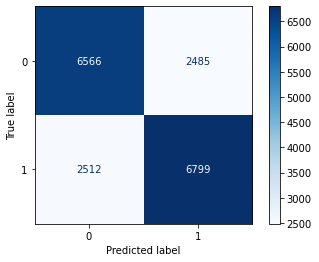

              precision    recall  f1-score   support

          CT     0.7233    0.7254    0.7244      9051
           T     0.7323    0.7302    0.7313      9311

    accuracy                         0.7279     18362
   macro avg     0.7278    0.7278    0.7278     18362
weighted avg     0.7279    0.7279    0.7279     18362



In [13]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(Entrenamiento, EntrenamientoResult)
Prediccion = KNN.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))

### 4.1.2 - Regresion Logística

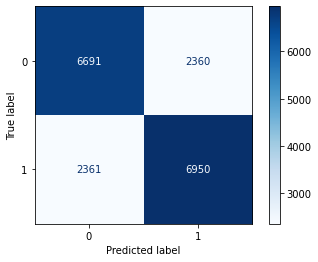

              precision    recall  f1-score   support

          CT     0.7392    0.7393    0.7392      9051
           T     0.7465    0.7464    0.7465      9311

    accuracy                         0.7429     18362
   macro avg     0.7428    0.7428    0.7428     18362
weighted avg     0.7429    0.7429    0.7429     18362



In [63]:
LR = LogisticRegression(random_state=27, max_iter=10000)
LR.fit(Entrenamiento, EntrenamientoResult)
Prediccion = LR.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))

### 4.1.3 - Decission Tree

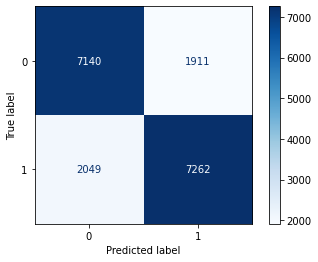

              precision    recall  f1-score   support

          CT     0.7770    0.7889    0.7829      9051
           T     0.7917    0.7799    0.7858      9311

    accuracy                         0.7843     18362
   macro avg     0.7843    0.7844    0.7843     18362
weighted avg     0.7844    0.7843    0.7843     18362



In [62]:
DT = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=None, random_state=2277)
DT.fit(Entrenamiento, EntrenamientoResult)
Prediccion = DT.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))

### 4.1.4 - AdaBoost

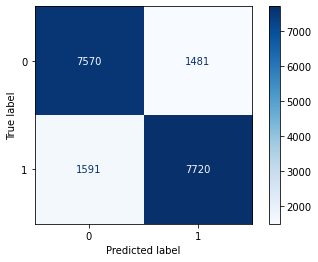

              precision    recall  f1-score   support

          CT     0.8263    0.8364    0.8313      9051
           T     0.8390    0.8291    0.8341      9311

    accuracy                         0.8327     18362
   macro avg     0.8327    0.8327    0.8327     18362
weighted avg     0.8328    0.8327    0.8327     18362



In [65]:
DT = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=None, random_state=2277)
AB = AdaBoostClassifier(base_estimator = DT, n_estimators=100, random_state=2277)
AB.fit(Entrenamiento, EntrenamientoResult)
Prediccion = AB.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))


### 4.1.5 - RandomForest

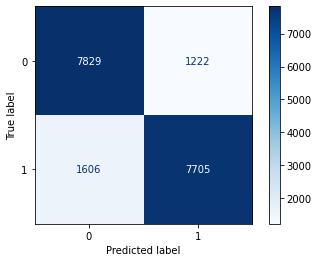

              precision    recall  f1-score   support

          CT     0.8298    0.8650    0.8470      9051
           T     0.8631    0.8275    0.8449      9311

    accuracy                         0.8460     18362
   macro avg     0.8464    0.8463    0.8460     18362
weighted avg     0.8467    0.8460    0.8460     18362



In [15]:
RF = RandomForestClassifier(n_estimators=100,criterion='gini', n_jobs=-1)
RF.fit(Entrenamiento, EntrenamientoResult)
Prediccion = RF.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))

### 4.2 - Modelo elegido (Random Forest)

El modelo que mejores resultados ha dado se ha conseguido mediante el clasificador Random Forest usando el criterio de entropía y 500 estimadores. Se ha intentado usar `GridSearchCV()` para la optimización de hiperparámetros pero el coste computacional que suponía era demasiado alto para el tiempo del que se disponía asi que se ha tenido que ir probando manualmente distintos valores de los hiperparámetros hasta llegar a los mencionados.

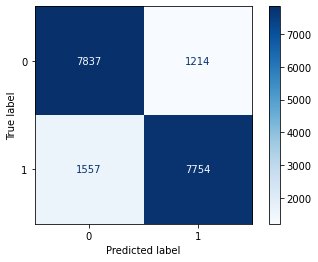

              precision    recall  f1-score   support

          CT     0.8343    0.8659    0.8498      9051
           T     0.8646    0.8328    0.8484      9311

    accuracy                         0.8491     18362
   macro avg     0.8494    0.8493    0.8491     18362
weighted avg     0.8497    0.8491    0.8491     18362



In [10]:
RF = RandomForestClassifier(n_estimators=500,criterion='entropy', n_jobs=-1)
RF.fit(Entrenamiento, EntrenamientoResult)
Prediccion = RF.predict(Test)

cm = confusion_matrix(TestResult, Prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(classification_report(TestResult, Prediccion, digits = 4))

In [15]:
rf1 = RandomForestClassifier(n_estimators=500,criterion='entropy', n_jobs=-1).fit(datosTrain, datosWinner)
prediccionRF = rf1.predict(datosTest)

#Preparación y guardado
solucionRF = pd.DataFrame({'id':datosTestId['id'], 'round_winner': prediccionRF})
solucionRF.to_csv('envio19.txt', sep = ',', index = False)

prediccionRF

array(['CT', 'T', 'T', ..., 'T', 'CT', 'T'], dtype=object)

Text(0.5, 1.0, 'Histograma de round_winner')

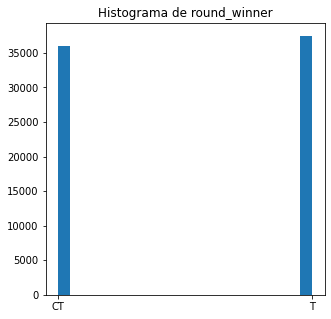

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

#Histograma para visualizar la distribución de los datos de time_left
ax.hist(datosEstudio["round_winner"], bins='auto')
ax.set_title("Histograma de round_winner")

Este modelo ha obtenido una valoracion F1 final de 0.86161 a la hora de predecir los datos objetivo, la cual es bastante mayor que lo que se obtendría con la "Zero Rule" (aportando como predicción siempre la clase más común, T en este caso), al estar repartidas mas o menos equitativamente las clases solución, por lo que se puede considerar como un modelo que aporta valor. También se puede considerar como un buen modelo ya que se ha ajustado bien a datos con los que no ha sido entrenado, por lo que no tiene overfitting.

Video explicativo : https://drive.google.com/file/d/1GlFTv8TfftQab4SxkMXNmrFlk-Vx-VNX/view?usp=sharing

Francisco Javier Burgos Banegas - Grupo 25
